In [14]:
import sys
from copy import deepcopy
from pathlib import Path
from addict import Dict

sys.path.append('../../')

In [15]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit

from examples.utils.config import Config
from examples.utils.dataset_adapters import fcx1_dataset
from spikebench import TrainNormalizeTransform, TsfreshVectorizeTransform, TsfreshFeaturePreprocessorPipeline
from spikebench.utils import simple_undersampling
from spikebench.train_encoders import ISIShuffleTransform
from spikebench.mpladeq import prettify, beautify_mpl, boxplot

beautify_mpl()

In [17]:
config_dict = {
    'seed': 0,
    'window': 50,
    'step': 50,
    'scale': True,
    'remove_low_variance': True,
    'train_subsample_factor': 0.7,
    'test_subsample_factor': 0.7,
    'feature_set': 'full',
    'delimiter': ',',
    'dataset': '../../data/fcx1',
    'n_trees': 200,
}

config = Config(config_dict)
np.random.seed(config.seed)

In [18]:
dataset = Path(config.dataset)
wake_spikes = fcx1_dataset(dataset / 'wake.parq')

In [19]:
shuffler = ISIShuffleTransform()
wake_spikes_shuffled = shuffler.transform(
    deepcopy(wake_spikes), format='pandas', delimiter=config.delimiter
)

In [20]:
group_split = GroupShuffleSplit(n_splits=1, test_size=0.5)
X = np.hstack([wake_spikes.series.values, wake_spikes_shuffled.series.values])
y = np.hstack([np.ones(wake_spikes.shape[0]), np.zeros(wake_spikes_shuffled.shape[0])])
groups = np.hstack([wake_spikes.groups.values, wake_spikes_shuffled.groups.values])

In [21]:
for train_index, test_index in group_split.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame({'series': X_train, 'groups': groups[train_index]})
X_test = pd.DataFrame({'series': X_test, 'groups': groups[test_index]})

In [22]:
normalizer = TrainNormalizeTransform(
    window=config.window, 
    step=config.step, 
    n_samples=None
)
X_train, y_train = normalizer.transform(X_train, y_train, delimiter=config.delimiter)
X_test, y_test = normalizer.transform(X_test, y_test, delimiter=config.delimiter)

In [23]:
vectorizer = TsfreshVectorizeTransform(feature_set=config.feature_set)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

Feature Extraction: 100%|██████████| 120/120 [01:19<00:00,  1.50it/s]


In [24]:
preprocessing = TsfreshFeaturePreprocessorPipeline(
        do_scaling=config.scale, 
        remove_low_variance=config.remove_low_variance,
    ).construct_pipeline()

preprocessing.fit(X_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)

In [25]:
print('Dataset size: train {}, test {}'.format(X_train.shape, X_test.shape))
print('Average target: train {}, test {}'.format(y_train.mean(), y_test.mean()))

Dataset size: train (27342, 389), test (23866, 389)
Average target: train 0.5, test 0.5


In [26]:
num_trials = 10

model = RandomForestClassifier(
    n_estimators=config.n_trees,
    random_state=config.seed,
    max_depth=10,
    n_jobs=-1
)

result_table_columns = ['trial', 'feature_set',
                        'accuracy_test', 'auc_roc_test',
                        'accuracy_train', 'auc_roc_train']
results = {key: [] for key in result_table_columns}
baseline_feature_names = [
    'abs_energy',
    'mean',
    'median',
    'minimum',
    'maximum',
    'standard_deviation',
]
baseline_feature_names = ['value__' + name for name
                            in baseline_feature_names]
metrics_to_collect = {'accuracy': accuracy_score, 'auc_roc': roc_auc_score}

for trial_idx in range(num_trials):
        X_train_sample_balanced, y_train_sample_balanced = simple_undersampling(
            X_train, y_train, subsample_size=config.train_subsample_factor
        )
        X_test_sample_balanced, y_test_sample_balanced = simple_undersampling(
            X_test, y_test, subsample_size=config.test_subsample_factor
        )

        model.fit(X_train_sample_balanced, y_train_sample_balanced)
        for (X, y), dataset_label in [((X_test_sample_balanced, y_test_sample_balanced), 'test'),
                                      ((X_train_sample_balanced, y_train_sample_balanced), 'train')]:
            for metric_name, metric_fn in metrics_to_collect.items():
                model_predictions = model.predict(X) \
                    if metric_name not in ['auc_roc'] else model.predict_proba(X)[:, 1]
                results[metric_name + '_' + dataset_label].append(metric_fn(y, model_predictions))
        results['feature_set'].append(config.feature_set)
        results['trial'].append(trial_idx)

        X_train_sample_balanced = X_train_sample_balanced.loc[:, baseline_feature_names]
        X_test_sample_balanced = X_test_sample_balanced.loc[:, baseline_feature_names]

        model.fit(X_train_sample_balanced, y_train_sample_balanced)

        for (X, y), dataset_label in [((X_test_sample_balanced, y_test_sample_balanced), 'test'),
                                      ((X_train_sample_balanced, y_train_sample_balanced), 'train')]:
            for metric_name, metric_fn in metrics_to_collect.items():
                model_predictions = model.predict(X) \
                    if metric_name not in ['auc_roc'] else model.predict_proba(X)[:, 1]
                results[metric_name + '_' + dataset_label].append(metric_fn(y, model_predictions))

        results['feature_set'].append('simple_baseline')
        results['trial'].append(trial_idx)
    
results = pd.DataFrame(results)

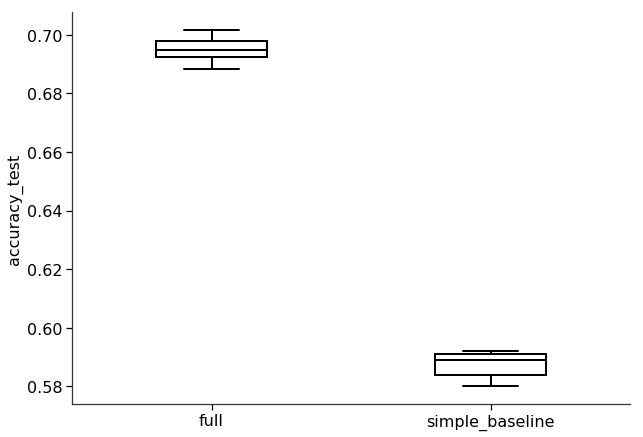

In [27]:
boxplot(x='feature_set', y='accuracy_test', data=results, notch=False)